In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [15]:
!pip install numpy librosa matplotlib scikit-learn tensorflow torch torchaudio

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 27.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 21.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [6]:
# Define the column headers
headers = ["onset", "offset", "pitch", "string_number", "fret_number", 
           "plucking_style", "expression_style", "modulation_frequency", "modulation_range"]

# Define the path to the dataset folder
dataset_path = "./IDMT-SMT-BASS-SINGLE-TRACKS/misc/notes_csv/"  # Change this to your actual path

# List all CSV files in the folder
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]

# Initialize a dictionary to store files that contain slap techniques
slap_files = {}

# Process each CSV file
for file in csv_files:
    file_path = os.path.join(dataset_path, file)
    
    # Load CSV with headers
    df = pd.read_csv(file_path, names=headers)
    
    # Filter for slap techniques (ST, SP)
    slap_df = df[df["plucking_style"].isin(["ST", "SP"])]
    
    if not slap_df.empty:
        slap_files[file] = len(slap_df)  # Store file name and count of slap notes

# Display files that contain slap techniques
if slap_files:
    print("\nCSV Files Containing Slap Techniques (ST, SP):")
    for file, count in slap_files.items():
        print(f"{file}: {count} slap notes found")
else:
    print("\nNo files with slap techniques found.")



CSV Files Containing Slap Techniques (ST, SP):
007_note_parameters.csv: 56 slap notes found
013_note_parameters.csv: 56 slap notes found
016_note_parameters.csv: 52 slap notes found


# Visualize Slap Bass

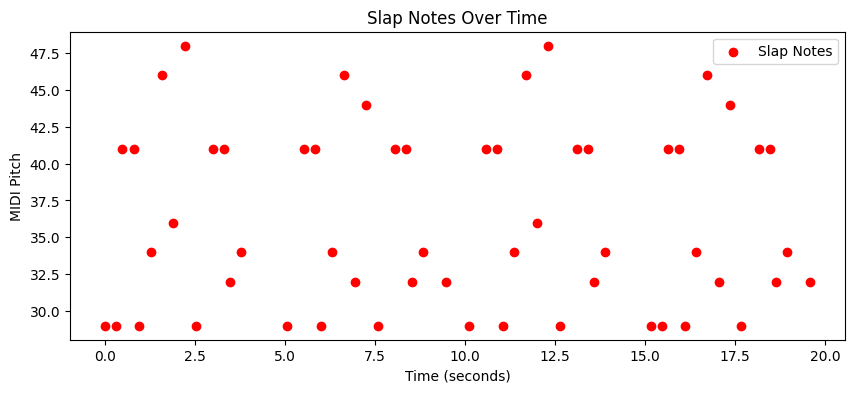

In [14]:
df = pd.read_csv(dataset_path+"007_note_parameters.csv", names=headers)

# Filter slap techniques
slap_df = df[df["plucking_style"].isin(["ST", "SP"])]

# Plot the distribution of slap notes over time
plt.figure(figsize=(10, 4))
plt.scatter(slap_df["onset"], slap_df["pitch"], c="red", label="Slap Notes")
plt.xlabel("Time (seconds)")
plt.ylabel("MIDI Pitch")
plt.title("Slap Notes Over Time")
plt.legend()
plt.show()


# Visualize Waveforms & Spectograms

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the corresponding audio file (adjust path as needed)
audio_file = "./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav"
y_audio, sr = librosa.load(audio_file, sr=None)  # Use original sampling rate (44.1kHz)

# Loop through slap notes and visualize one or a few
for i, row in slap_df.iterrows():
    onset = row["onset"]
    offset = row["offset"]
    pluck_type = row["plucking_style"]
    
    # Convert times to sample indices
    start_sample = int(onset * sr)
    end_sample = int(offset * sr)
    segment = y_audio[start_sample:end_sample]

    # Plot waveform
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(segment, sr=sr)
    plt.title(f"{pluck_type} Note (onset: {onset:.2f}s)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Plot spectrogram
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=1024, hop_length=256)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - {pluck_type}")
    plt.tight_layout()
    plt.show()

    # Optional: break after 3 notes for testing
    if i >= 10:
        break


# Feature Extraction & Build Dataset

## 007 Feature Extraction & Classifier (POC)

In [26]:
import numpy as np

# Create lists to hold features and labels
X = []
y = []

# Loop over all slap notes and extract MFCC features
for i, row in slap_df.iterrows():
    onset = row["onset"]
    offset = row["offset"]
    label = row["plucking_style"]  # "ST" or "SP"
    
    start_sample = int(onset * sr)
    end_sample = int(offset * sr)
    segment = y_audio[start_sample:end_sample]

    # Skip very short segments
    # if len(segment) < 2048:
    #     continue

    # Extract MFCCs (take mean over time to flatten into 1D vector)
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    X.append(mfcc_mean)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Feature shape: {X.shape}")
print(f"Labels: {np.unique(y)}")


Feature shape: (56, 13)
Labels: ['SP' 'ST']


In [34]:
X

array([[-5.4279364e+02,  1.7588744e+02,  3.1119236e+01, ...,
        -5.4971542e+00, -1.0766131e+01, -2.0593314e+00],
       [-6.3071161e+02,  1.7763579e+02,  4.5650898e+01, ...,
         1.4830404e+01,  5.1634827e+00, -1.9814106e+00],
       [-4.1015317e+02,  1.6687607e+02, -2.8713873e+01, ...,
        -1.0605835e+00, -1.2887118e+00, -7.6300797e+00],
       ...,
       [-4.2241779e+02,  1.6322862e+02, -4.5347420e+01, ...,
         2.0307028e+00,  6.8632311e-01,  1.2590764e+00],
       [-5.9069940e+02,  1.9275137e+02,  4.7785019e+01, ...,
         4.5131526e+00,  1.4911944e+00,  6.2783966e+00],
       [-5.5327576e+02,  1.7946069e+02,  9.3336878e+00, ...,
        -3.1445378e-01, -3.1571786e+00, -4.6217732e+00]], dtype=float32)

In [37]:
y

array(['ST', 'ST', 'SP', 'SP', 'ST', 'ST', 'SP', 'ST', 'SP', 'ST', 'SP',
       'SP', 'ST', 'ST', 'ST', 'SP', 'SP', 'ST', 'ST', 'SP', 'ST', 'SP',
       'ST', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST', 'SP', 'SP', 'ST', 'ST',
       'SP', 'ST', 'SP', 'ST', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST', 'SP',
       'SP', 'ST', 'ST', 'SP', 'ST', 'SP', 'ST', 'SP', 'SP', 'ST', 'ST',
       'ST', 'ST', 'ST', 'ST', 'ST', 'ST', 'SP', 'ST', 'ST', 'ST', 'ST',
       'ST', 'ST', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST', 'ST', 'SP', 'ST',
       'ST', 'ST', 'ST', 'ST', 'ST', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST',
       'ST', 'SP', 'ST', 'ST', 'ST', 'ST', 'ST', 'ST', 'SP', 'SP', 'ST',
       'ST', 'ST', 'ST', 'ST', 'SP', 'ST', 'ST', 'ST', 'ST', 'ST', 'ST',
       'SP', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST', 'ST', 'SP', 'ST', 'ST',
       'ST', 'ST', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST', 'ST', 'SP', 'ST',
       'ST', 'ST', 'ST', 'SP', 'ST', 'SP', 'SP', 'ST', 'ST', 'ST', 'ST',
       'ST', 'SP', 'ST', 'ST', 'ST', 'ST', 'SP', 'S

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          SP       1.00      1.00      1.00         5
          ST       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



### Get all Slap Bass Data

In [28]:
import pandas as pd
import os

# Define headers based on dataset spec
headers = ["onset", "offset", "pitch", "string_number", "fret_number", 
           "plucking_style", "expression_style", "modulation_frequency", "modulation_range"]

# Define folder paths
csv_folder = "./IDMT-SMT-BASS-SINGLE-TRACKS/misc/notes_csv/"
audio_folder = "./IDMT-SMT-BASS-SINGLE-TRACKS/audio"

# Get all CSV files
csv_files = sorted([f for f in os.listdir(csv_folder) if f.endswith(".csv")])

# Master DataFrame for all slap notes
slap_notes_all = []

for csv_file in csv_files:
    file_path = os.path.join(csv_folder, csv_file)
    df = pd.read_csv(file_path, names=headers)

    # Keep only slap notes
    slap_df = df[df["plucking_style"].isin(["ST", "SP"])].copy()
    
    if not slap_df.empty:
        audio_filename = csv_file.replace("_note_parameters.csv", ".wav")
        slap_df["audio_file"] = os.path.join(audio_folder, audio_filename)
        slap_df["source_csv"] = csv_file
        slap_notes_all.append(slap_df)

# Combine all into one DataFrame
all_slap_notes_df = pd.concat(slap_notes_all, ignore_index=True)

# Preview the slap note dataset
print(f"Total slap notes: {len(all_slap_notes_df)}")
print(all_slap_notes_df[["onset", "offset", "plucking_style", "audio_file"]].head())


Total slap notes: 164
     onset   offset plucking_style  \
0  0.00000  0.31578             ST   
1  0.31578  0.47367             ST   
2  0.47370  0.63159             SP   
3  0.78948  0.94739             SP   
4  0.94739  1.26320             ST   

                                    audio_file  
0  ./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav  
1  ./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav  
2  ./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav  
3  ./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav  
4  ./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav  


In [30]:
all_slap_notes_df[["onset", "offset", "plucking_style", "audio_file"]]

,onset,offset,plucking_style,audio_file
0,0.00000,0.31578,ST,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav
1,0.31578,0.47367,ST,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav
2,0.47370,0.63159,SP,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav
3,0.78948,0.94739,SP,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav
4,0.94739,1.26320,ST,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/007.wav
...,...,...,...,...
159,17.70000,17.85000,ST,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/016.wav
160,17.85000,18.24480,ST,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/016.wav
161,18.30000,18.45000,SP,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/016.wav
162,18.60000,18.90000,ST,./IDMT-SMT-BASS-SINGLE-TRACKS/audio/016.wav


## All Slap Bass Data Feature Extraction 

In [31]:
import numpy as np
import librosa

# Lists to store features and labels
X = []
y = []

# Loop through all slap notes from all files
for idx, row in all_slap_notes_df.iterrows():
    onset = row["onset"]
    offset = row["offset"]
    label = row["plucking_style"]
    audio_file = row["audio_file"]
    
    try:
        # Load the corresponding audio file once
        y_audio, sr = librosa.load(audio_file, sr=None)

        # Convert times to sample indices
        start_sample = int(onset * sr)
        end_sample = int(offset * sr)

        # Extract the segment
        segment = y_audio[start_sample:end_sample]

        # Skip very short segments
        if len(segment) < 2048:
            continue

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Flatten over time

        # Append to dataset
        X.append(mfcc_mean)
        y.append(label)

    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

# Convert to arrays
X = np.array(X)
y = np.array(y)

print(f"Total extracted samples: {len(X)}")
print(f"Feature shape: {X.shape}")
print(f"Label distribution: {np.unique(y, return_counts=True)}")


Total extracted samples: 164
Feature shape: (164, 13)
Label distribution: (array(['SP', 'ST'], dtype='<U2'), array([ 50, 114]))


              precision    recall  f1-score   support

          SP     1.0000    0.9000    0.9474        10
          ST     0.9583    1.0000    0.9787        23

    accuracy                         0.9697        33
   macro avg     0.9792    0.9500    0.9630        33
weighted avg     0.9710    0.9697    0.9692        33



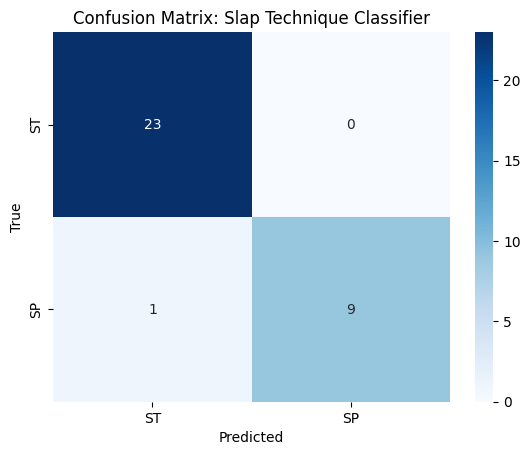

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=["ST", "SP"])
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["ST", "SP"], yticklabels=["ST", "SP"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Slap Technique Classifier")
plt.show()


### Save Dataset

In [38]:
import numpy as np

# Save feature set and labels
np.save("X.npy", X)
np.save("y.npy", y)

print("Dataset saved as X.npy and y.npy")

Dataset saved as X.npy and y.npy


## Cross Validation & Hyperparameter Tuning

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Run GridSearchCV
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Best parameters & accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Train best model
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9938


## Save Model

In [40]:
import joblib

# Save the best model
joblib.dump(best_rf, "random_forest_slap_classifier.pkl")

print("Model saved as random_forest_slap_classifier.pkl")


Model saved as random_forest_slap_classifier.pkl
